In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. Preprocessing

### Data Gathering

In [4]:
indexes = []
all_indexes = {}

In [5]:
index_excel_file = '../Data/Index_Data.xlsx'
all_indexes = pd.read_excel(index_excel_file, sheet_name=None)

for sheet_name, df in all_indexes.items():
    indexes.append(sheet_name)
    all_indexes[sheet_name] = df

In [6]:
BSESN = all_indexes['BSESN']
BSESN.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price
6803,2025-02-11 00:00:00+05:30,77384.976562,77387.281250,76030.593750,76293.601562,9800,0,0,-0.013170
6804,2025-02-12 00:00:00+05:30,76188.242188,76459.718750,75388.390625,76171.078125,10400,0,0,-0.001606
6805,2025-02-13 00:00:00+05:30,76201.101562,76764.531250,76013.429688,76138.968750,6900,0,0,-0.000422
6806,2025-02-14 00:00:00+05:30,76388.992188,76483.062500,75439.640625,75939.210938,9300,0,0,-0.002624
6807,2025-02-17 00:00:00+05:30,75641.406250,76041.960938,75294.757812,75996.859375,0,0,0,0.000759


In [7]:
len(BSESN)

6808

### Feature Engineering

In [8]:
BSESN['Date'] = pd.to_datetime(BSESN['Date'])
BSESN = BSESN.sort_values('Date').reset_index(drop=True)

In [9]:
BSESN['52W_High'] = BSESN['High'].rolling(window=252, min_periods=1).max()
BSESN['52W_Low'] = BSESN['Low'].rolling(window=252, min_periods=1).min()

In [10]:
features = ['Open', 'Close', '52W_High', '52W_Low']
target = 'Close'

In [11]:
X_data = BSESN[features].values
y_data = BSESN['Close'].values.reshape(-1, 1)

In [12]:
y_data

array([[ 4300.85986328],
       [ 4333.89990234],
       [ 4323.45996094],
       ...,
       [76138.96875   ],
       [75939.2109375 ],
       [75996.859375  ]])

In [13]:
len(X_data)

6808

### Data Normalization

In [14]:
# Normalize the data
# scaler_features = MinMaxScaler(feature_range=(0, 1))
# scaler_target = MinMaxScaler(feature_range=(0, 1))
# scaled_X_data = scaler_features.fit_transform(X_data)
# scaled_y_data = scaler_target.fit_transform(y_data)


scaler_features = StandardScaler()
scaler_target = StandardScaler()
scaled_X_data = scaler_features.fit_transform(X_data)
scaled_y_data = scaler_target.fit_transform(y_data)

### Create Sequences

In [15]:
# Create sequences for LSTM
def create_sequences(features, target, seq_length=90):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i, :])  # Use all features
        y.append(target[i, 0])  # Predict `Close` price
    return np.array(X), np.array(y)

In [16]:
X, y = create_sequences(scaled_X_data, scaled_y_data)

In [17]:
len(y)

6718

In [18]:
y[-2:]

array([2.58472466, 2.58756534])

In [19]:
X[-1:]

array([[[2.87821133, 2.85711593, 2.89873162, 2.67959043],
        [2.87220744, 2.86422666, 2.89873162, 2.67959043],
        [2.85476708, 2.85289091, 2.89873162, 2.67959043],
        [2.85961451, 2.88204679, 2.89873162, 2.67959043],
        [2.88546401, 2.87451106, 2.89873162, 2.67959043],
        [2.86304541, 2.85880401, 2.89873162, 2.67959043],
        [2.86853455, 2.8344248 , 2.89873162, 2.67959043],
        [2.81885684, 2.84517386, 2.89873162, 2.67959043],
        [2.86912317, 2.84155324, 2.89873162, 2.67959043],
        [2.83884095, 2.79569941, 2.89873162, 2.67959043],
        [2.77807686, 2.78886278, 2.89873162, 2.67959043],
        [2.78680108, 2.78803394, 2.89873162, 2.67959043],
        [2.79118608, 2.75537063, 2.89873162, 2.67959043],
        [2.76490608, 2.78507162, 2.89873162, 2.67959043],
        [2.78379259, 2.80300763, 2.89873162, 2.67959043],
        [2.79367328, 2.78197417, 2.89873162, 2.67959043],
        [2.78417423, 2.75471888, 2.89873162, 2.67959043],
        [2.783

### Data splitting

In [20]:
training_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.9)

X_train, X_validate, X_test = X[:training_size], X[training_size:validation_size], X[validation_size:]
y_train, y_validate, y_test = y[:training_size], y[training_size:validation_size], y[validation_size:]

print(len(X))
print(f"{len(X_train)}")
print(f"{len(X_validate)}")
print(f"{len(X_test)}")
print(f"{len(y_test)}")

6718
4702
1344
672
672


In [21]:
print(X.shape)
print(f"{X_train.shape}")
print(f"{X_validate.shape}")
print(f"{X_test.shape}")
print(f"{y_test.shape}")

(6718, 90, 4)
(4702, 90, 4)
(1344, 90, 4)
(672, 90, 4)
(672,)


# 2. Model creation

### Plot epoch vs loss & epoch vs mae

In [22]:
def plot_loss_mae(history):
    # Extract values from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']

    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'bo-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r^-', label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training vs Validation MAE')
    plt.legend()

    plt.show()

### LSTM model

2025-02-18 14:05:10.983091: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-18 14:05:10.983119: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-18 14:05:10.983125: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-18 14:05:10.983979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-18 14:05:10.984252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-02-18 14:05:12.242846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-18 14:05:12.449174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-18 14:05:12.518985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/147 [..............................] - ETA: 3:29 - loss: 0.3317 - mean_absolute_error: 0.4678

2025-02-18 14:05:12.681677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-18 14:05:12.784511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - ETA: 0s - loss: 0.1316 - mean_absolute_error: 0.2948

2025-02-18 14:05:16.899324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-18 14:05:16.966228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-18 14:05:17.009805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - 6s 31ms/step - loss: 0.1316 - mean_absolute_error: 0.2948 - val_loss: 0.5884 - val_mean_absolute_error: 0.6417
Epoch 2/20
147/147 [==============================] - 4s 29ms/step - loss: 0.0105 - mean_absolute_error: 0.0734 - val_loss: 0.3637 - val_mean_absolute_error: 0.4872
Epoch 3/20
147/147 [==============================] - 4s 28ms/step - loss: 0.0043 - mean_absolute_error: 0.0473 - val_loss: 0.4787 - val_mean_absolute_error: 0.5751
Epoch 4/20
147/147 [==============================] - 4s 28ms/step - loss: 0.0053 - mean_absolute_error: 0.0473 - val_loss: 0.2826 - val_mean_absolute_error: 0.4604
Epoch 5/20
147/147 [==============================] - 4s 28ms/step - loss: 0.0021 - mean_absolute_error: 0.0329 - val_loss: 0.4629 - val_mean_absolute_error: 0.5671
Epoch 6/20
147/147 [==============================] - 4s 28ms/step - loss: 7.1313e-04 - mean_absolute_error: 0.0202 - val_loss: 0.5383 - val_mean_absolute_error: 0.6023
Epoch 7/20
147/14

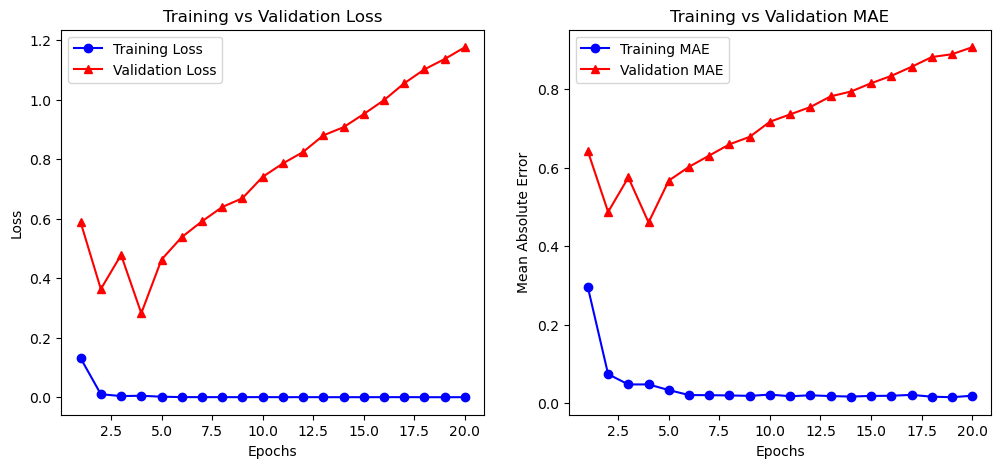

In [23]:
# # LSTM Model

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(128, return_sequences=True)(inputs)
x = LSTM(64, return_sequences=False)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

output = Dense(1)(x)


model = Model(inputs, output)

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_validate, y_validate))

plot_loss_mae(history)